# Problem 1

# Structured Data Assignement

### The dataset in question contains a comprehensive collection of electronic health records belonging to patients who have been diagnosed with a specific disease. These health records comprise a detailed log of every aspect of the patients' medical history, including all diagnoses, symptoms, prescribed drug treatments, and medical tests that they have undergone. Each row represents a healthcare record/medical event for a patient and it includes a timestamp for each entry/event, thereby allowing for a chronological view of the patient's medical history.

#### The Data has mainly three columns

### Patient-Uid - Unique Alphanumeric Identifier for a patient
### Date - Date when patient encountered the event.
### Incident - This columns describes which event occurred on the day.

# Objective

##### To develop a predictive model which will predict whether a patient will be eligible*** for “Target Drug” or not in next 30 days. Knowing if the patient is eligible or not will help physician treating the patient make informed decision on the which treatments to give.

##### A patient is considered eligible for a particular drug when they have taken their first prescription for that drug.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_curve,auc
from datetime import datetime, timedelta

In [17]:
# read the train and test data
train_df = pd.read_parquet("train.parquet")
test_df = pd.read_parquet("test.parquet")

In [19]:
train_df.groupby('Patient-Uid').max()
test_df.groupby('Patient-Uid').max()
train_df.groupby('Patient-Uid').max()
test_df.groupby('Patient-Uid').max()

,Date,Incident
Patient-Uid,,
a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2019-05-21,TEST_TYPE_0
a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2019-10-23,TEST_TYPE_3
a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-10-21,TEST_TYPE_1
a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2020-03-21,TEST_TYPE_0
a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2019-11-09,SYMPTOM_TYPE_3
...,...,...
a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-03-24,DRUG_TYPE_7
a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_8
a102726b-1c7c-11ec-bfbf-16262ee38c7f,2020-01-02,DRUG_TYPE_7


In [20]:
train_df.sort_values(by = ['Date'], inplace=True)
test_df.sort_values(by = ['Date'], inplace=True)
#converting date column to pandas datetime type
train_df['Date']=pd.to_datetime(train_df['Date'],format='%Y-%m-%d')

In [21]:
positive_set=train_df[train_df['Incident'] == 'TARGET DRUG']

# Set the current date as a reference point
current_date = positive_set.Date.max()

# Calculate the cutoff date 30 days before the current date
cutoff_date = current_date - timedelta(days=30)

# Filter the data for patients who have taken "Target Drug" within the last 30 days
positive_set = train_df[(train_df['Incident'] == 'TARGET DRUG') & (train_df['Date'] >= cutoff_date)]

In [22]:
negative_set = train_df[train_df['Incident'] != 'TARGET DRUG'].sample(frac=1)[:len(positive_set)] 

In [23]:
# Combine the positive and negative sets
data = pd.concat([positive_set, negative_set])

# Sort the data by date
data = data.sort_values(by='Date')

# Create a target variable indicating whether the patient is eligible or not
data['Eligible'] = np.where(data['Incident'] == 'TARGET DRUG', 1, 0)

In [24]:
data.reset_index(drop=True)

,Patient-Uid,Date,Incident,Eligible
0,a0ecbc2e-1c7c-11ec-8ee5-16262ee38c7f,2015-04-07,DRUG_TYPE_8,0
1,a0e82813-1c7c-11ec-8ef8-16262ee38c7f,2015-04-09,DRUG_TYPE_2,0
2,a0e060e7-1c7c-11ec-b507-16262ee38c7f,2015-04-09,SYMPTOM_TYPE_7,0
3,a0ec2406-1c7c-11ec-b68b-16262ee38c7f,2015-04-09,TEST_TYPE_0,0
4,a0def04e-1c7c-11ec-9926-16262ee38c7f,2015-04-11,SYMPTOM_TYPE_3,0
...,...,...,...,...
5777,a0ec380c-1c7c-11ec-8748-16262ee38c7f,2020-09-03,TARGET DRUG,1
5778,a0eef62d-1c7c-11ec-990a-16262ee38c7f,2020-09-03,TARGET DRUG,1
5779,a0eb94c9-1c7c-11ec-98ea-16262ee38c7f,2020-09-03,TARGET DRUG,1
5780,a0eba474-1c7c-11ec-b39e-16262ee38c7f,2020-09-03,TARGET DRUG,1


# Freq features

In [25]:
freq_features = data.groupby('Patient-Uid').agg({'Incident': 'count'}).reset_index()
freq_features.columns = ['Patient-Uid', 'Freq']

# Time features

In [26]:
time_features = data.groupby('Patient-Uid').agg({'Date': ['min', 'max']}).reset_index()
time_features.columns = ['Patient-Uid', 'Min_Date', 'Max_Date']
time_features['Time_Diff'] = (pd.to_datetime(current_date) - time_features['Max_Date']).dt.days

In [27]:
data = pd.merge(data, freq_features, on='Patient-Uid', how='left')
data = pd.merge(data, time_features, on='Patient-Uid', how='left')

In [28]:
data.isnull().sum()
data.fillna(0,inplace=True)

In [29]:
features = ['Freq', 'Time_Diff']
target = 'Eligible'
X=data[features]
y=data[target]

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

# Make predictions on the validation set
y_pred = rf.predict(X_test)
f1 = f1_score(y_test,y_pred)

print(f"F1 score: {f1:.3f}")

F1 score: 0.915


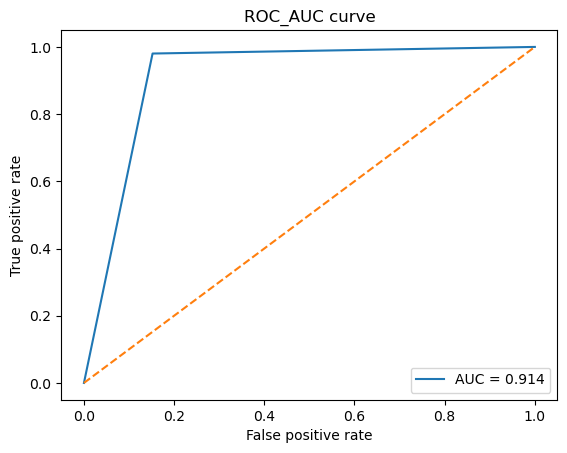

In [47]:
# evaluating model by roc_auc curve
fpr,tpr, thresold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.title('ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lg = model.predict(X_test)
f1=f1_score(y_test,y_pred_lg)

print(f"F1 score: {f1:.3f}")

F1 score: 0.906


In [35]:
# KNN model
knn = KNeighborsClassifier(4)
knn.fit(X_train,y_train)

# Make predictions on the validation set
y_pred_knn=knn.predict(X_test)
f1=f1_score(y_test,y_pred_knn)
print(f"F1 score: {f1:.3f}")

F1 score: 0.874


# Prediction on test_data

In [37]:
df1=pd.read_parquet("test.parquet")


In [38]:
test_data=df1[:100000]

In [39]:
test_data.shape

(100000, 3)

In [40]:
test_data.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [41]:
current_date_1=df1['Date'].max()

In [42]:
# Create the features
test_freq_features = test_data.groupby('Patient-Uid').agg({'Incident': 'count'}).reset_index()
test_freq_features.columns = ['Patient-Uid', 'Freq']

test_time_features = test_data.groupby('Patient-Uid').agg({'Date': ['min', 'max']}).reset_index()
test_time_features.columns = ['Patient-Uid', 'Min_Date', 'Max_Date']
test_time_features['Time_Diff'] = (pd.to_datetime('2020-08-04') - test_time_features['Max_Date']).dt.days

# Merge the features
test_data = pd.merge(test_data, test_freq_features, on='Patient-Uid', how='left')
test_data = pd.merge(test_data, test_time_features, on='Patient-Uid', how='left')

# Fill missing values with 0
test_data.fillna(0, inplace=True)

In [43]:
# Make predictions on the test data
test_data['label'] = rf.predict(test_data[features])

In [44]:
# Save the predictions to a CSV file
test_data[['Patient-Uid', 'label']].to_csv('final_submission.csv', index=False)
 

In [50]:
final_submission=pd.read_csv("final_submission.csv")
final_submission.head(10)

,Patient-Uid,label
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
5,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
6,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
7,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
8,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
9,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0


In [51]:
final_submission["label"].value_counts()

0    96131
1     3869
Name: label, dtype: int64